In [3]:
import os
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
SYM_PATH = '/content/gdrive/MyDrive/cs285_f2022/proj'
%cd $SYM_PATH

/content/gdrive/MyDrive/cs285_f2022/proj


In [1]:
#!pip install contextualbandits
!pip install git+https://github.com/HaodongL/cs285_proj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/HaodongL/cs285_proj to /tmp/pip-req-build-q31z8kb8
  Running command git clone -q https://github.com/HaodongL/cs285_proj /tmp/pip-req-build-q31z8kb8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for contextualbandits: filename=contextualbandits-0.3.19-cp38-cp38-linux_x86_64.whl size=1294648 sha256=9b712705870ce3e9c86268abc371cfc64a61458f0008608db7fb2f024ca92e86
  Stored in directory: /tmp/pip-ephem-wheel-cache-5cd1tiwt/wheels/17/0a/30/3c93bb6cfafe38041ba0e83f45fbed1c1d33170f1161f37622
Successfully built contextualbandits


In [ ]:
!pip install costsensitive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for costsensitive: filename=costsensitive-0.1.2.13.post6-cp37-cp37m-linux_x86_64.whl size=76523 sha256=1bdc737cfe8c9d4e39255b4f1cdfe9f09c3fc29a0aab02265509c877619cae9e
  Stored in directory: /root/.cache/pip/wheels/6e/7c/73/6226eeb7dfea1687df052bee5752ae739b9c00b4a884d8df1b
Successfully built costsensitive


In [ ]:
# Policy evaluation

In [5]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

features, y = parse_data("Bibtex_data.txt")
print(features.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


In [6]:
from sklearn.linear_model import LogisticRegression

# the 'explorer' polcy will be fit to this small sample of the rows
st_seed = 0
end_seed = 2000

# then it will choose actions for this larger sample, which will be the input for the new policy
st_exploration = 0
end_exploration = 3000

# the new policy will be evaluated with a separate test set
st_test = 3000
end_test = 7395

# separating the covariates data for each case
Xseed = features[st_seed:end_seed, :]
Xexplore_sample = features[st_exploration:end_exploration, :]
Xtest = features[st_test:end_test, :]
nchoices = y.shape[1]

# now constructing an exploration policy as explained above, with fully-labeled data
explorer = LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000)
explorer.fit(Xseed, np.argmax(y[st_seed:end_seed], axis=1))

# letting the exploration policy choose actions for the new policy input
actions_explore_sample=explorer.predict(Xexplore_sample)
rewards_explore_sample=y[st_exploration:end_exploration, :]\
                        [np.arange(end_exploration - st_exploration), actions_explore_sample]

# extracting the probabilities it estimated
ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions = [ix_internal_actions[i] for i in actions_explore_sample]
ix_internal_actions = np.array(ix_internal_actions)
prob_actions_explore = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                               ix_internal_actions]

# generating a test set with random actions
actions_test = np.random.randint(nchoices, size=end_test - st_test)
rewards_test = y[st_test:end_test, :][np.arange(end_test - st_test), actions_test]

In [23]:
# Rejection sampling estimate:
from contextualbandits.online import SeparateClassifiers
from contextualbandits.evaluation import evaluateRejectionSampling

new_policy = SeparateClassifiers(LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                 y.shape[1], smoothing=(1,2), beta_prior=None, random_state=123)
new_policy.fit(Xexplore_sample, actions_explore_sample, rewards_explore_sample)
est_r, ncases = evaluateRejectionSampling(new_policy, X=Xtest, a=actions_test, r=rewards_test,
                                          online=False)
real_r = np.mean(y[st_test:end_test,:][np.arange(end_test - st_test), new_policy.predict(Xtest)])

print('Test set Rejection Sampling mean reward estimate (new policy)')
print('Estimated mean reward: ',est_r)
print('Sample size: ', ncases)
print('----------------')
print('Real mean reward: ', real_r)

Test set Rejection Sampling mean reward estimate (new policy)
Estimated mean reward:  0.21428571428571427
Sample size:  28
----------------
Real mean reward:  0.1447098976109215


In [15]:
est_r, ncases = evaluateRejectionSampling(explorer, X=Xtest, a=actions_test, r=rewards_test, online=False)
real_r = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), explorer.predict(Xtest)])

print('Test set Rejection Sampling mean reward estimate (old policy)')
print('Estimated mean reward: ', est_r)
print('Sample size: ', ncases)
print('----------------')
print('Real mean reward: ', real_r)

Test set Rejection Sampling mean reward estimate (old policy)
Estimated mean reward:  0.4117647058823529
Sample size:  34
----------------
Real mean reward:  0.4814562002275313


In [16]:
# try DR (new policy)
from contextualbandits.evaluation import evaluateDoublyRobust
# import statsmodels.api as sm

prob_actions_test = np.array([1/nchoices] * len(actions_test))


# actions that the new policy will choose
pred = new_policy.predict(Xtest)


# method 2: estimating rewards by fitting another model to the test data only
est_r_dr_test_only = evaluateDoublyRobust(pred, X=Xtest, a=actions_test,
                                          r=rewards_test, p=prob_actions_test,
                                          reward_estimator=LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                          nchoices=y.shape[1], random_state=123)

real_r = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print('Test set mean reward estimates (new policy)')
print('DR estimate (reward estimator fit on test only): ', est_r_dr_test_only)
print('----------------')
print('Real mean reward: ', real_r)

Test set mean reward estimates (new policy)
DR estimate (reward estimator fit on test only):  0.13288557604022555
----------------
Real mean reward:  0.1447098976109215


In [17]:
# try TMLE (new policy)
from contextualbandits.evaluation import evaluateTMLE
# import statsmodels.api as sm

prob_actions_test = np.array([1/nchoices] * len(actions_test))


# actions that the new policy will choose
pred = new_policy.predict(Xtest)


# method 2: estimating rewards by fitting another model to the test data only
est_r_tmle_test_only = evaluateTMLE(pred, X=Xtest, a=actions_test,
                                          r=rewards_test, p=prob_actions_test,
                                          reward_estimator=LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                          nchoices=y.shape[1], random_state=123)

real_r = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print('Test set mean reward estimates (new policy)')
print('TMLE estimate (reward estimator fit on test only): ', est_r_tmle_test_only)
print('----------------')
print('Real mean reward: ', real_r)

Test set mean reward estimates (new policy)
TMLE estimate (reward estimator fit on test only):  0.1328864208445578
----------------
Real mean reward:  0.1447098976109215


In [ ]:
# Plot

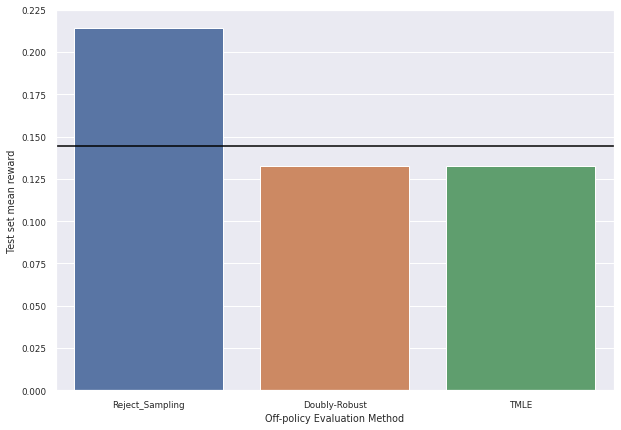

In [27]:
import matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
from pylab import rcParams
%matplotlib inline

results = pd.DataFrame({
    'Off-policy Evaluation Method' : ['Reject_Sampling', 'Doubly-Robust','TMLE'],
    'Test set mean reward' : [est_r, est_r_dr_test_only, est_r_tmle_test_only]
})

sns.set(font_scale = 0.8)
rcParams['figure.figsize'] = 10, 7
sns.barplot(x = "Off-policy Evaluation Method", y="Test set mean reward", data=results)
plt.axhline(y=real_r, color='black', linestyle='-')
# plt.title('Off-policy evaluation on Bibtex dataset (classifier is logistic regression)')
plt.savefig("p_offpolicy_eval")

In [ ]:
# Biased sample

In [ ]:
actions_test_biased = explorer.predict(Xtest)
rewards_test_biased = y[st_test:end_test, :][np.arange(end_test - st_test), actions_test_biased]
est_r, ncases = evaluateRejectionSampling(new_policy, X=Xtest, a=actions_test_biased,
                                          r=rewards_test_biased, online=False)
real_r = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])

print('Biased Test set Rejection Sampling mean reward estimate (new policy)')
print('Estimated mean reward: ', est_r)
print('Sample size: ', ncases)
print('----------------')
print('Real mean reward: ', real_r)
print("(Don't try rejection sampling on a biased test set)")

Biased Test set Rejection Sampling mean reward estimate (new policy)
Estimated mean reward:  1.0
Sample size:  551
----------------
Real mean reward:  0.1447098976109215
(Don't try rejection sampling on a biased test set)


In [ ]:
from contextualbandits.evaluation import evaluateDoublyRobust
# import statsmodels.api as sm

# getting estimated probabilities for the biased test sample chosen by the old policy
ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions = [ix_internal_actions[i] for i in actions_test_biased]
ix_internal_actions = np.array(ix_internal_actions)
prob_actions_test_biased = explorer.predict_proba(Xtest)[np.arange(Xtest.shape[0]), ix_internal_actions]


# actions that the new policy will choose
pred = new_policy.predict(Xtest)

# method 1: estimating rewards by fitting another model to the whole data (train + test)
model_fit_on_all_data = SeparateClassifiers(LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                            y.shape[1], random_state=123)
model_fit_on_all_data.fit(np.r_[Xexplore_sample, Xtest],
                          np.r_[actions_explore_sample, actions_test_biased],
                          np.r_[rewards_explore_sample, rewards_test_biased])
est_r_dr_whole = evaluateDoublyRobust(pred,
                                      X=Xtest, a=actions_test_biased, r=rewards_test_biased,
                                      p=prob_actions_test_biased, reward_estimator=model_fit_on_all_data,
                                      random_state=123)

# method 2: estimating rewards by fitting another model to the test data only
est_r_dr_test_only = evaluateDoublyRobust(pred, X=Xtest, a=actions_test_biased,
                                          r=rewards_test_biased, p=prob_actions_test_biased,
                                          reward_estimator=LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                          nchoices=y.shape[1], random_state=123)

print('Biased Test set mean reward estimates (new policy)')
print('DR estimate (reward estimator fit on train+test): ', est_r_dr_whole)
print('DR estimate (reward estimator fit on test only): ', est_r_dr_test_only)
print('----------------')
print('Real mean reward: ', real_r)

Biased Test set mean reward estimates (new policy)
DR estimate (reward estimator fit on train+test):  0.7806511111850939
DR estimate (reward estimator fit on test only):  0.7838130617873124
----------------
Real mean reward:  0.1447098976109215


In [ ]:
from contextualbandits.evaluation import evaluateDoublyRobust
# import statsmodels.api as sm

# getting estimated probabilities for the biased test sample chosen by the old policy
# ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
# ix_internal_actions = [ix_internal_actions[i] for i in actions_test_biased]
# ix_internal_actions = np.array(ix_internal_actions)
# prob_actions_test_biased = explorer.predict_proba(Xtest)[np.arange(Xtest.shape[0]), ix_internal_actions]

# temp
actions_test_biased = actions_test
prob_actions_test_biased = np.array([1/len(actions_test)] * len(actions_test))
rewards_test_biased = rewards_test 

# actions that the new policy will choose
# pred = new_policy.predict(Xtest)
# temp
pred = explorer.predict(Xtest)

# method 1: estimating rewards by fitting another model to the whole data (train + test)
model_fit_on_all_data = SeparateClassifiers(LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                            y.shape[1], random_state=123)
model_fit_on_all_data.fit(np.r_[Xexplore_sample, Xtest],
                          np.r_[actions_explore_sample, actions_test_biased],
                          np.r_[rewards_explore_sample, rewards_test_biased])
est_r_dr_whole = evaluateDoublyRobust(pred,
                                      X=Xtest, a=actions_test_biased, r=rewards_test_biased,
                                      p=prob_actions_test_biased, reward_estimator=model_fit_on_all_data,
                                      random_state=123)

# method 2: estimating rewards by fitting another model to the test data only
est_r_dr_test_only = evaluateDoublyRobust(pred, X=Xtest, a=actions_test_biased,
                                          r=rewards_test_biased, p=prob_actions_test_biased,
                                          reward_estimator=LogisticRegression(C=0.1, solver="lbfgs", max_iter=15000),
                                          nchoices=y.shape[1], random_state=123)

print('Biased Test set mean reward estimates (new policy)')
print('DR estimate (reward estimator fit on train+test): ', est_r_dr_whole)
print('DR estimate (reward estimator fit on test only): ', est_r_dr_test_only)
print('----------------')
print('Real mean reward: ', real_r)

Biased Test set mean reward estimates (new policy)
DR estimate (reward estimator fit on train+test):  0.6295344115377745
DR estimate (reward estimator fit on test only):  0.17204916680517077
----------------
Real mean reward:  0.4814562002275313
